# **Machine learning for network traffic classification**

## Description
The dataset was gathered from the Canadian Institute for Cybersecurity, it contains more than 225,000 examples of network connections to different devices labeled as DDoS or benign attacks.
Various machine learning models are applied and evaluated for classification.

## Download the dataset
https://www.kaggle.com/datasets/aymenabb/ddos-evaluation-dataset-cic-ddos2019

## Import libraries

In [3]:
import pandas as pd
import ipaddress
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from sklearn.metrics import cluster, silhouette_score, calinski_harabasz_score, f1_score, recall_score, precision_score
from IPython.display import FileLink
import joblib

## 1. Data visualization and preprocessing

In [5]:
df_orig = pd.read_csv("data.csv")
#Trabajo con una copia del dataset
df = df_orig.copy()
df

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,192.168.10.15-72.21.91.29-61374-80-6,72.21.91.29,80,192.168.10.15,61374,6,7/7/2017 5:02,61,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225741,192.168.10.15-72.21.91.29-61378-80-6,72.21.91.29,80,192.168.10.15,61378,6,7/7/2017 5:02,72,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225742,192.168.10.15-72.21.91.29-61375-80-6,72.21.91.29,80,192.168.10.15,61375,6,7/7/2017 5:02,75,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225743,192.168.10.15-8.41.222.187-61323-80-6,8.41.222.187,80,192.168.10.15,61323,6,7/7/2017 5:02,48,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 85 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow ID                      225745 non-null  object 
 1   Source IP                    225745 non-null  object 
 2   Source Port                  225745 non-null  int64  
 3   Destination IP               225745 non-null  object 
 4   Destination Port             225745 non-null  int64  
 5   Protocol                     225745 non-null  int64  
 6   Timestamp                    225745 non-null  object 
 7   Flow Duration                225745 non-null  int64  
 8   Total Fwd Packets            225745 non-null  int64  
 9   Total Backward Packets       225745 non-null  int64  
 10  Total Length of Fwd Packets  225745 non-null  int64  
 11  Total Length of Bwd Packets  225745 non-null  int64  
 12  Fwd Packet Length Max        225745 non-null  int64  
 13 

### 1.1 Delete the 'Flow ID' attribute
The 'Flow ID' attribute is dispensable as it contains information represented in other attributes. It is removed to avoid duplication of information.

In [8]:
df = df.drop('Flow ID', axis = 1)

### 1.2 Transforming object-type features into integers

In [10]:
df['Source IP'] = df['Source IP'].apply(lambda x: int(ipaddress.IPv4Address(x)))
df['Destination IP'] = df['Destination IP'].apply(lambda x : int(ipaddress.IPv4Address(x)))

In [11]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True, errors='coerce').astype('int64') // 10**9

In [12]:
df['Label'] = (df['Label'] == 'DDoS').astype(int)

### 1.3 Correlation among features and 'Label'
NaN values appear for certain attributes because their values are constant across all examples. That is, they do not vary regardless of how the example is labeled and therefore do not influence the final result.

In [14]:
df.corr()['Label'].sort_values(ascending=False)

Label                     1.000000
Bwd Packet Length Mean    0.603299
Avg Bwd Segment Size      0.603299
Bwd Packet Length Max     0.577323
Bwd Packet Length Std     0.576155
                            ...   
Fwd Avg Packets/Bulk           NaN
Fwd Avg Bulk Rate              NaN
Bwd Avg Bytes/Bulk             NaN
Bwd Avg Packets/Bulk           NaN
Bwd Avg Bulk Rate              NaN
Name: Label, Length: 84, dtype: float64

Example of a constant value feature:

In [16]:
df['Fwd Avg Packets/Bulk'].value_counts()

Fwd Avg Packets/Bulk
0    225745
Name: count, dtype: int64

Delete the constant value features

In [18]:
constants_cols = df.columns[df.nunique() == 1]
print("Constants columns:", constants_cols.tolist())

Constants columns: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


In [19]:
df.drop(columns = constants_cols, inplace = True)

### 1.4 Checking that the 'Label' attribute is not unbalanced

In [21]:
df['Label'].value_counts()

Label
1    128027
0     97718
Name: count, dtype: int64

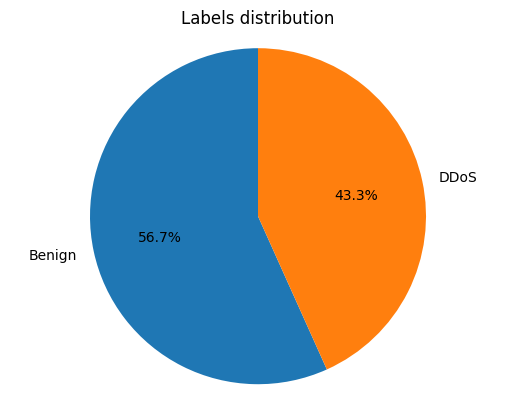

In [22]:
labels = ['Benign', 'DDoS']
sizes = [128025/225711*100, 97686/225711*100]

plt.pie(sizes, labels = labels, autopct = '%1.1f%%', startangle = 90)
plt.axis('equal')
plt.title('Labels distribution')

plt.show()

### 1.5 Splitting and scaling the data set
Before scaling the data set, any infinite or NaN values are removed to avoid the error 'ValueError: Input X contains infinity or a value too large for dtype('float64')'.

In [24]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
num_nan = df.isna().any(axis = 1).sum()
print("Deleted rows:",num_nan)
df = df.dropna()

Deleted rows: 34


Split the data into training, validation, and testing subsets.

In [26]:
train_set, test_set = train_test_split(df, test_size = 0.1, random_state = 42, stratify = df['Label'])
val_set, test_set = train_test_split(test_set, test_size = 0.5, random_state = 42, stratify = test_set['Label'])

X_train = train_set.drop('Label', axis = 1)
y_train = train_set['Label'].copy()

X_val = val_set.drop('Label', axis = 1)
y_val = val_set['Label'].copy()

X_test = test_set.drop('Label', axis = 1)
y_test = test_set['Label'].copy()

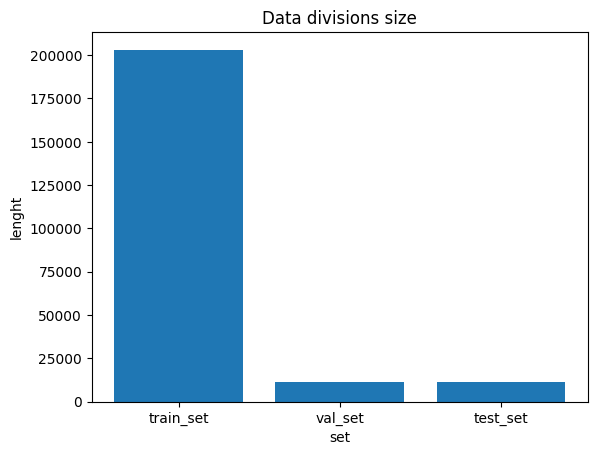

In [27]:
data = [len(train_set), len(val_set), len(test_set)]
labels = ['train_set', 'val_set', 'test_set']

plt.figure()
plt.bar(labels, data)
plt.xlabel('set')
plt.ylabel('lenght')
plt.title('Data divisions size')

plt.show()

I generate a new dataset by scaling the values in the current one using RobustScaler. This allows us to compare the model's behavior with scaled and unscaled data, and also demonstrates the importance of scaling in data preprocessing.

In [29]:
scaler = RobustScaler()

X_scaled_train = scaler.fit_transform(X_train)
X_scaled_val = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)

We trained a KNNImputer with the scaled training data. It won't be used in this file, but it will be useful for applying the model to new data collected.

In [31]:
imputer = KNNImputer(n_neighbors=5)
imputer.fit(X_scaled_train)

KNNImputer()

Reconstructing the DataFrames separately

In [33]:
df_train = pd.DataFrame(X_train, columns = X_train.columns, index = X_train.index)
df_train['Label'] = y_train.values

df_val = pd.DataFrame(X_val, columns = X_val.columns, index = X_val.index)
df_val['Label'] = y_val.values

df_test = pd.DataFrame(X_test, columns = X_test.columns, index = X_test.index)
df_test['Label'] = y_test.values


df_scaled_train = pd.DataFrame(X_scaled_train, columns = X_train.columns, index = X_train.index)
df_scaled_train['Label'] = y_train.values

df_scaled_val = pd.DataFrame(X_scaled_val, columns = X_val.columns, index = X_val.index)
df_scaled_val['Label'] = y_val.values

df_scaled_test = pd.DataFrame(X_scaled_test, columns = X_test.columns, index = X_test.index)
df_scaled_test['Label'] = y_test.values

In [34]:
df_scaled_train

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
18190,1.000000,-0.307583,-9.591837e-01,-27.0,11.0,-0.923077,-0.166473,-0.333333,-0.50,1.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
77729,0.000000,0.312947,0.000000e+00,0.0,0.0,-0.307692,9.125167,1.666667,0.25,0.684211,...,0.0,1662.468344,0.0,1662.468344,1678.924024,9.339154,0.0,9.323456,10.358473,1
129302,1.000000,-1.263993,-7.051192e+06,55070.0,0.0,0.153846,10.199402,1.333333,1.25,304.815789,...,0.0,13.248742,0.0,13.248742,13.379882,5.445818,50500000.0,9.759357,1.238545,0
115877,0.000000,0.093765,0.000000e+00,0.0,0.0,0.076923,9.859929,1.666667,0.00,0.684211,...,0.0,0.001589,0.0,0.001589,0.001605,5.276015,47700000.0,9.347672,1.308497,1
181522,0.000000,0.399288,0.000000e+00,0.0,0.0,0.615385,0.734598,0.666667,-1.00,0.000000,...,0.0,0.527152,0.0,0.527152,0.532370,0.954893,0.0,0.953288,1.059114,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15790,0.038135,-1.254764,-7.142857e-01,58389.0,0.0,-1.153846,-0.162691,0.000000,-0.75,0.526316,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
1234,1.000000,0.357694,-9.591837e-01,-27.0,11.0,-2.769231,-0.163683,0.333333,0.00,3.842105,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
22186,1.000000,0.289887,-1.000000e+00,-27.0,11.0,-0.769231,-0.159646,-0.666667,-0.75,0.578947,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
205733,1.000000,0.267184,-1.495306e+07,363.0,0.0,1.769231,-0.084444,2.666667,1.00,14.657895,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0


## 2. Logistic Regression

In [56]:
lr_clf = LogisticRegression(solver='saga',C = 1, max_iter = 1000, tol=1e-3, verbose = 1)
lr_clf.fit(X_scaled_train, y_train)

y_pred = lr_clf.predict(X_scaled_test)

convergence after 601 epochs took 169 seconds


In [57]:
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))

F1 Score: 0.5482948744129058
Recall: 0.41946570848304954
Precision: 0.7913351016799293


## 3. KMEANS

In [59]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
clusters = kmeans.fit_predict(X_scaled_train)

In [60]:
confusion_matrix = cluster.contingency_matrix(y_train, clusters)
purity = np.sum(np.amax(confusion_matrix, axis = 0)) / np.sum(confusion_matrix)
print("Purity:", purity)

Purity: 0.7688823908752135


In [61]:
print("Silhouette:", silhouette_score(X_scaled_train, clusters, sample_size = 10000))

Silhouette: 0.9286599087052413


In [62]:
print("Calinski harabasz: ", calinski_harabasz_score(X_scaled_train, clusters))

Calinski harabasz:  1705304.2356632438


## 4. Gaussian Naive Bayes

In [64]:
nb_clf = GaussianNB()
nb_clf.fit(X_scaled_train, y_train)

y_pred = nb_clf.predict(X_scaled_test)

In [65]:
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))

F1 Score: 0.8853683846419924
Recall: 0.9996875488204968
Precision: 0.7945120437049913


## 5. ANN (Scaled data vs Unscaled data)
Two identical neural networks are trained, one with unscaled data and the other with the scaled dataset, to demonstrate how data scaling positively affects the model, yielding much better results.

In [39]:
def create_network():
    network = models.Sequential()

    network.add(layers.Input(shape=X_train.shape[1:]))
    network.add(layers.Dense(64, activation = 'relu'))
    network.add(layers.Dense(32, activation = 'relu'))
    network.add(layers.Dense(1, activation = 'sigmoid'))

    network.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam())

    return network

### 5.1 Training and evaluation with unscaled data

In [69]:
network = create_network()
history = network.fit(X_train, y_train, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 1920444.2500 - val_loss: 54817.1641
Epoch 2/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 115615.1094 - val_loss: 26298.0684
Epoch 3/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 13023.8398 - val_loss: 68.6666
Epoch 4/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 768.2773 - val_loss: 0.5511
Epoch 5/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 71.0639 - val_loss: 0.6301
Epoch 6/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 0.6311 - val_loss: 0.6300
Epoch 7/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.6311 - val_loss: 0.6300
Epoch 8/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.6320 - val_loss: 0.6300
Epoch 9/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.6316 - val_loss: 0.6300
Epoch 10/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 0.6317 - val_loss: 0.6300


In [70]:
pred = network.predict(X_test)
y_pred = (pred > 0.5).astype("int32")
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))

353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
F1 Score: 0.7529702387954358
Recall: 1.0
Precision: 0.6038109612300726


### 5.2 Training and evaluation with scaled data

In [43]:
network = create_network()
history = network.fit(X_scaled_train, y_train, epochs = 10, validation_data = (X_scaled_val, y_val))

Epoch 1/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1842.5428 - val_loss: 1160.1105
Epoch 2/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 282.2688 - val_loss: 804.6928
Epoch 3/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 281.0389 - val_loss: 378.0495
Epoch 4/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 94.9998 - val_loss: 421.3861
Epoch 5/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 77.2242 - val_loss: 363.8324
Epoch 6/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 50.5058 - val_loss: 129.1305
Epoch 7/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 32.0544 - val_loss: 197.5892
Epoch 8/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 11.9877 - val_loss: 205.1111
Epoch 9/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 20.2737 - val_loss: 207.4366
Epoch 10/10
6349/6349 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 21.3089 - val_loss: 40.0948


In [73]:
pred_scaled = network.predict(X_scaled_test)
y_scaled_pred = (pred_scaled > 0.5).astype("int32")
print("SCALED F1 Score:", f1_score(y_test, y_scaled_pred))
print("SCALED Recall:", recall_score(y_test, y_scaled_pred))
print("SCALED Precision:", precision_score(y_test, y_scaled_pred))

353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  
SCALED F1 Score: 0.999687597625742
SCALED Recall: 0.9998437744102484
SCALED Precision: 0.9995314696236139


This test demonstrates how data scaling positively affects the model, getting a much better result. In the following sections, we will work only with the scaled data set.

## 6. Save the best model, the scaler and the imputer

In [58]:
network.save('trained_traffic_classifier.keras')
FileLink('trained_traffic_classifier.keras')

C:\Users\marco\Documents\otros\progra\DDos\trained_traffic_classifier.keras

In [61]:
joblib.dump(scaler, 'scaler.pkl')
FileLink('scaler.pkl')

C:\Users\marco\Documents\otros\progra\DDos\scaler.pkl

In [63]:
joblib.dump(imputer, 'imputer.pkl')
FileLink('imputer.pkl')

C:\Users\marco\Documents\otros\progra\DDos\imputer.pkl